## 진행사항
- 데이터 준비: 주어진 금융 데이터셋을 불러와서 근로기간이 누락된 부분을 확인하고, KNN Imputer를 사용하여 누락된 값 대체.
- 데이터 분포 비교: Imputer를 적용하기 전과 후의 데이터 분포를 비교하여 대체된 값이 어떤 특징을 가지는지 확인. 이를 통해 Imputer의 사용이 데이터 변환에 미치는 영향 분석.
- 근로기간 범주화 작업 진행.
- 인사이트 도출.

### import & data set

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
SEED = 42

train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
train_data=train_data.iloc[:,1:]
train_data

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [4]:
train_data.loc[train_data['근로기간']=='3','근로기간']='3 years'
test_data.loc[test_data['근로기간']=='3','근로기간']='3 years'
test_data.loc[test_data['근로기간']=='1 year','근로기간']='1 years'
train_data.loc[train_data['근로기간']=='1 year','근로기간']='1 years'
test_data.loc[test_data['근로기간']=='<1 year','근로기간']='< 1 year'
train_data.loc[train_data['근로기간']=='<1 year','근로기간']='< 1 year'
test_data.loc[test_data['근로기간']=='10+years','근로기간']='10+ years'
train_data.loc[train_data['근로기간']=='10+years','근로기간']='10+ years'
train_data.value_counts('근로기간')

근로기간
10+ years    32481
2 years       8450
< 1 year      8144
3 years       7670
1 years       6305
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
Name: count, dtype: int64

- 근로기간 데이터 확인 후 정리함.

In [5]:
values_map=dict({'6 years':6,
 '10+ years':10,
 '5 years':5,
 '8 years':8,
 '9 years':9,
 '2 years':2,
 '1 years':1,
 '3 years':3,
 '7 years':7,
 '4 years':4,
 '< 1 year':0})

In [6]:
train_data['근로기간'] = train_data['근로기간'].replace(values_map)

In [7]:
train_data['주택소유상태'] = train_data['주택소유상태'].replace({'ANY':'MORTGAGE'})

'ANY'를 'MORTGAGE'대체한 이유 : 가장 값이 많은 빈도 값을 임의로 넣었음..!

In [8]:
train_data['근로기간'].unique()

array([6, 10, 5, 8, 'Unknown', 9, 2, 1, 3, 7, 4, 0], dtype=object)

In [9]:
train_data['근로기간'].value_counts()['Unknown']


5671

Unknown 데이터 값이 5,671개

In [10]:
train_data['대출기간'] = train_data['대출기간'].str.strip().replace('months', '', regex=True).astype(float)
train_data

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36.0,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60.0,10,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36.0,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36.0,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60.0,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36.0,10,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60.0,10,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36.0,1,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36.0,5,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [11]:
group_train_data=train_data.groupby('대출등급',group_keys=True).apply(lambda x:x)
group_train_data

대출금액  대출기간 근로기간    주택소유상태       연간소득  부채_대비_소득_비율  총계좌수  \
대출등급                                                                      
A    2      12000000  36.0    5  MORTGAGE   96000000         8.60    14   
     5       4800000  36.0   10      RENT   84000000        13.78    30   
     13     12000000  36.0   10  MORTGAGE   48000000        11.94    11   
     17      9600000  36.0    8      RENT   74400000        11.98    35   
     21      8400000  36.0    7  MORTGAGE   42000000        19.00    22   
...              ...   ...  ...       ...        ...          ...   ...   
G    94294  17130000  60.0    7  MORTGAGE   50400000        21.23    25   
     94324  29100000  60.0    3  MORTGAGE   76800000        18.24    32   
     94543  42000000  60.0    4      RENT  114000000        10.30    12   
     95477  30000000  60.0    1  MORTGAGE  120000000        18.05    14   
     95658  10590000  36.0   10  MORTGAGE   31200000        29.59    19   

             대출목적  최근_2년간_연체_횟수   총상환원금      총상환이자  총연체금액  연체계좌수 대출등급  
대출등급                                                                   
A    2      부채 통합             0  928644   151944.0    0.0    0.0    A  
     5         휴가             0  240216    55428.0    0.0    0.0    A  
     13     부채 통합             1  303972    58236.0    0.0    0.0    A  
     17     부채 통합             0  476016   116268.0    0.0    0.0    A  
     21     주택 개선             0  850164   179196.0    0.0    0.0    A  
...           ...           ...     ...        ...    ...    ...  ...  
G    94294     기타             0  398892  1176840.0    0.0    0.0    G  
     94324  신용 카드             0  711108  1926708.0    0.0    0.0    G  
     94543  부채 통합             0  665388  2009016.0    0.0    0.0    G  
     95477  부채 통합             0  490824  1266156.0    0.0    0.0    G  
     95658  부채 통합             0  799176   921204.0    0.0    0.0    G  

[96294 rows x 14 columns]

In [12]:
train_data.dtypes

대출금액              int64
대출기간            float64
근로기간             object
주택소유상태           object
연간소득              int64
부채_대비_소득_비율     float64
총계좌수              int64
대출목적             object
최근_2년간_연체_횟수      int64
총상환원금             int64
총상환이자           float64
총연체금액           float64
연체계좌수           float64
대출등급             object
dtype: object

In [13]:
num_data=train_data.select_dtypes(['int64','float64'])
num_data

,대출금액,대출기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,36.0,72000000,18.90,15,0,0,0.0,0.0,0.0
1,14400000,60.0,130800000,22.33,21,0,373572,234060.0,0.0,0.0
2,12000000,36.0,96000000,8.60,14,0,928644,151944.0,0.0,0.0
3,14400000,36.0,132000000,15.09,15,0,325824,153108.0,0.0,0.0
4,18000000,60.0,71736000,25.39,19,0,228540,148956.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36.0,210000000,9.33,33,0,974580,492168.0,0.0,0.0
96290,28800000,60.0,132000000,5.16,25,0,583728,855084.0,0.0,0.0
96291,14400000,36.0,84000000,11.24,22,0,1489128,241236.0,0.0,0.0
96292,15600000,36.0,66330000,17.30,21,2,1378368,818076.0,0.0,0.0


In [14]:
object_data=train_data.select_dtypes(['object'])
object_data

,근로기간,주택소유상태,대출목적,대출등급
0,6,RENT,부채 통합,C
1,10,MORTGAGE,주택 개선,B
2,5,MORTGAGE,부채 통합,A
3,8,MORTGAGE,부채 통합,C
4,Unknown,RENT,주요 구매,B
...,...,...,...,...
96289,10,MORTGAGE,신용 카드,C
96290,10,MORTGAGE,주택 개선,E
96291,1,MORTGAGE,신용 카드,A
96292,5,MORTGAGE,부채 통합,D


In [15]:
num_data['대출등급']=train_data['대출등급']
num_data

,대출금액,대출기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36.0,72000000,18.90,15,0,0,0.0,0.0,0.0,C
1,14400000,60.0,130800000,22.33,21,0,373572,234060.0,0.0,0.0,B
2,12000000,36.0,96000000,8.60,14,0,928644,151944.0,0.0,0.0,A
3,14400000,36.0,132000000,15.09,15,0,325824,153108.0,0.0,0.0,C
4,18000000,60.0,71736000,25.39,19,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36.0,210000000,9.33,33,0,974580,492168.0,0.0,0.0,C
96290,28800000,60.0,132000000,5.16,25,0,583728,855084.0,0.0,0.0,E
96291,14400000,36.0,84000000,11.24,22,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36.0,66330000,17.30,21,2,1378368,818076.0,0.0,0.0,D


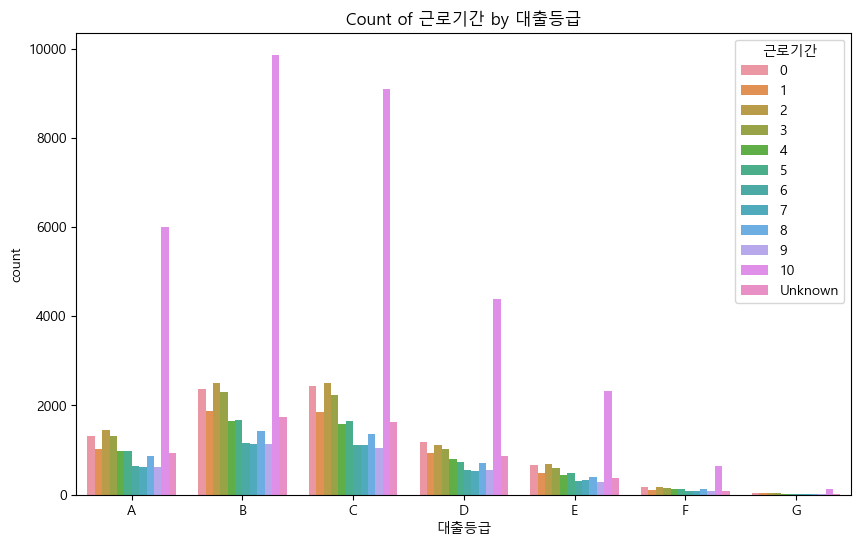

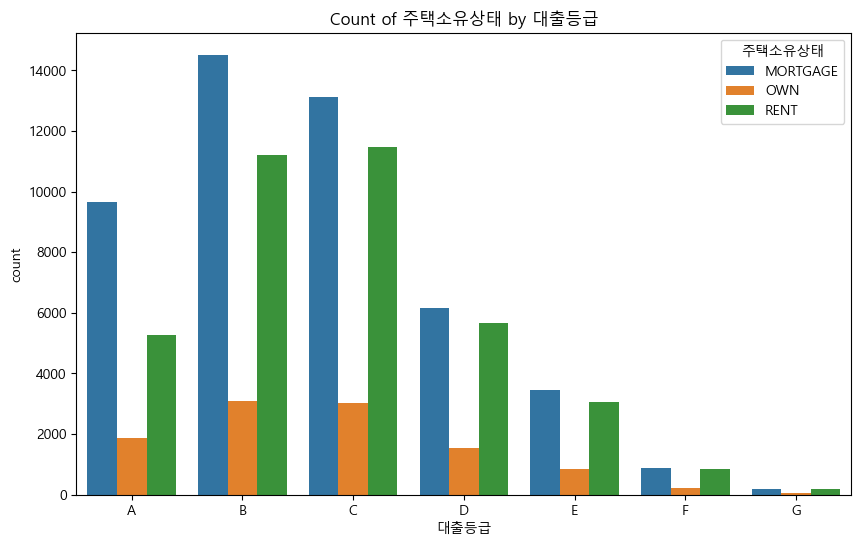

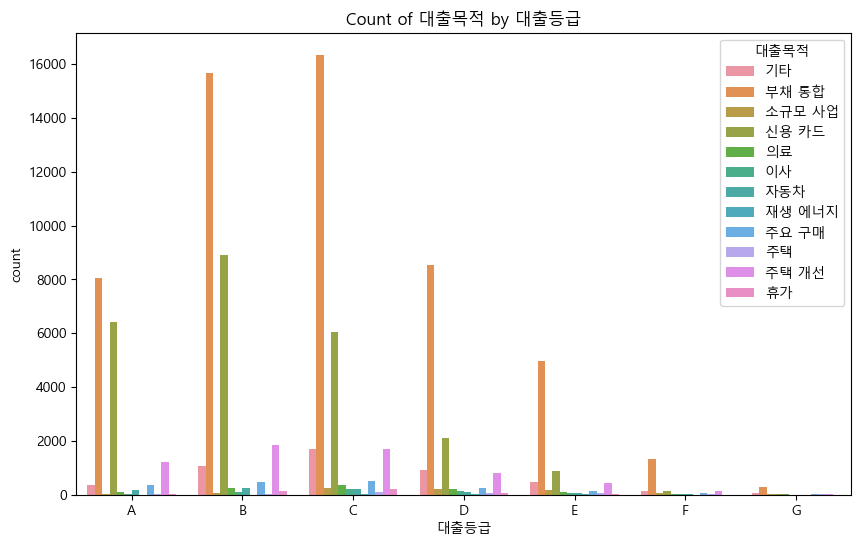

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


object_columns = object_data.select_dtypes(include=[object])

for column in object_columns.columns:
    if column != '대출등급': 
        count_data = object_data.groupby(['대출등급', column]).size().reset_index(name='count')
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='대출등급', y='count', hue=column, data=count_data)
        plt.title(f'Count of {column} by 대출등급')
        plt.show()

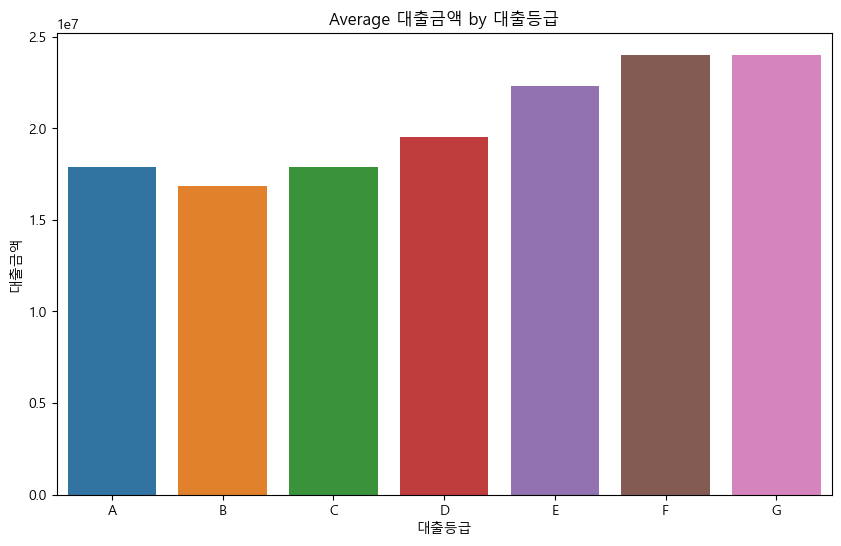

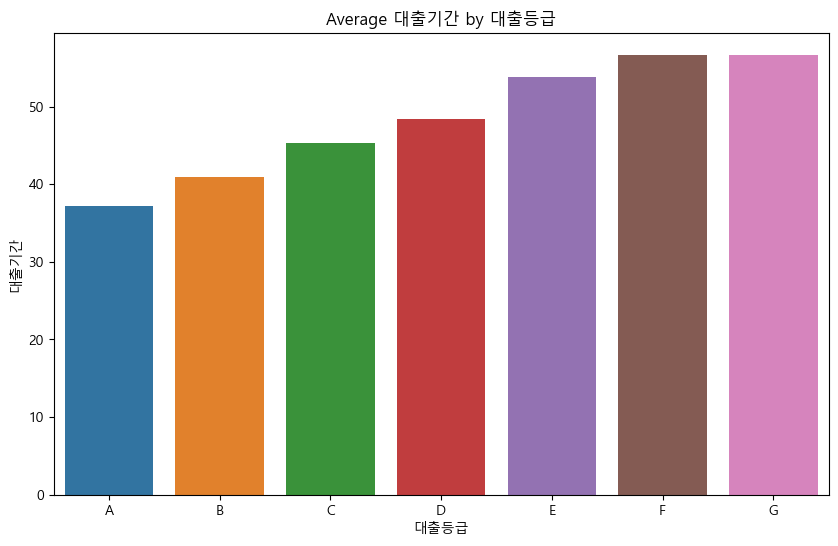

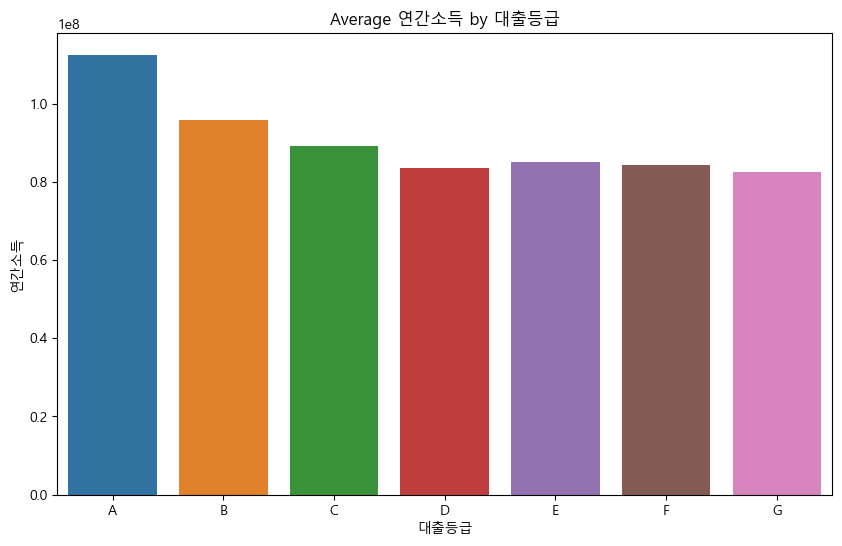

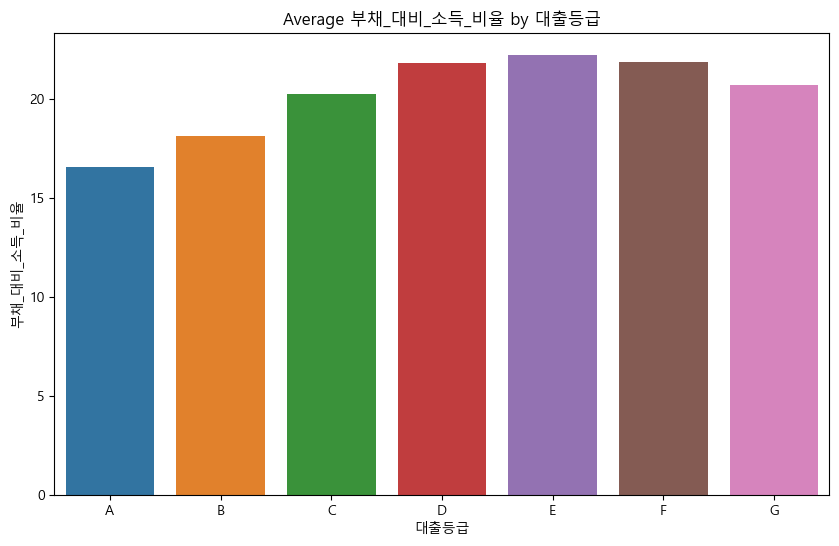

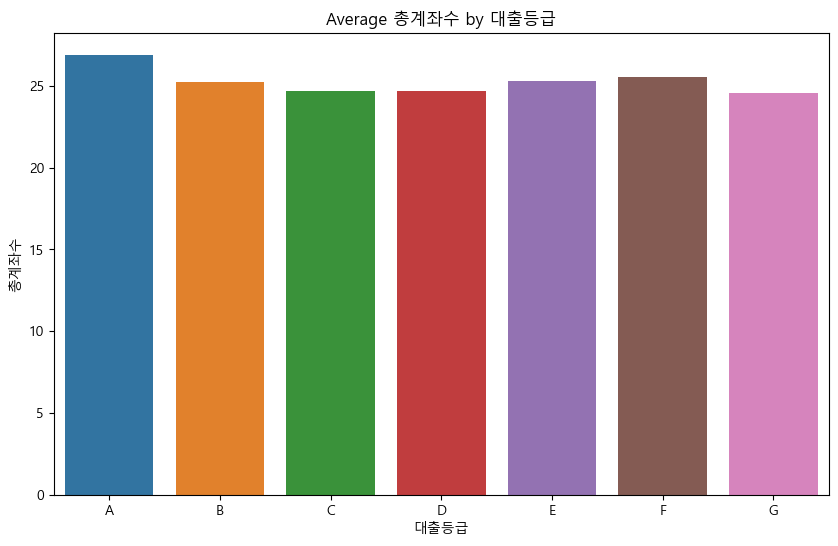

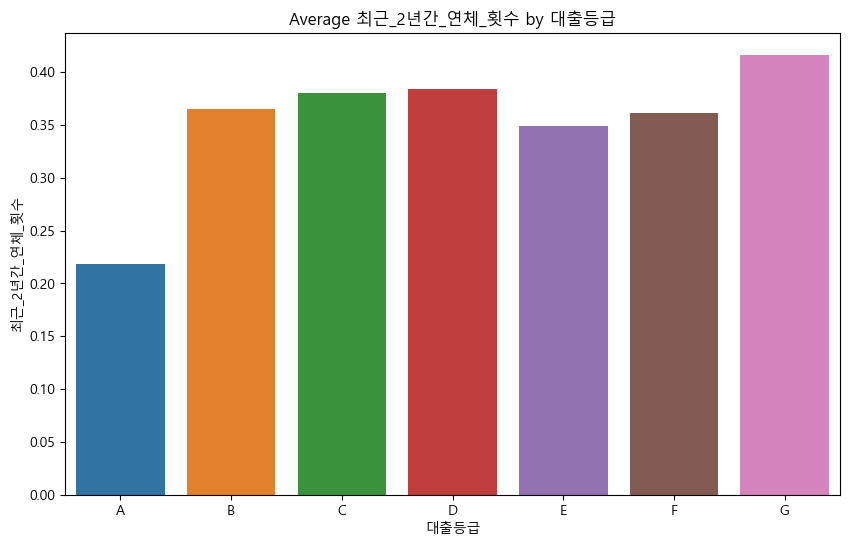

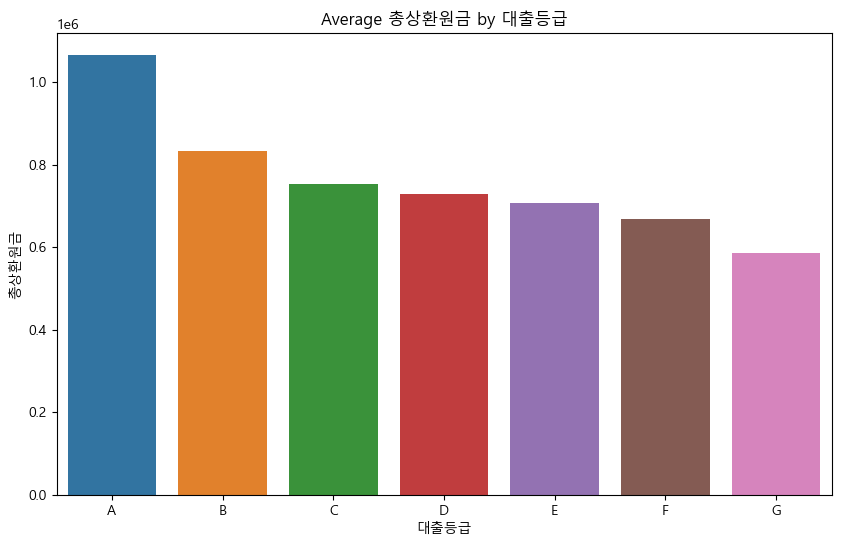

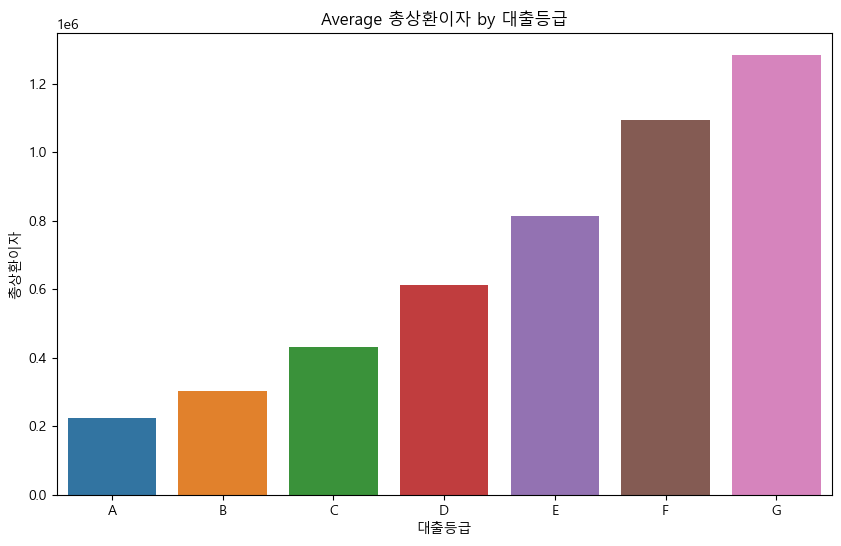

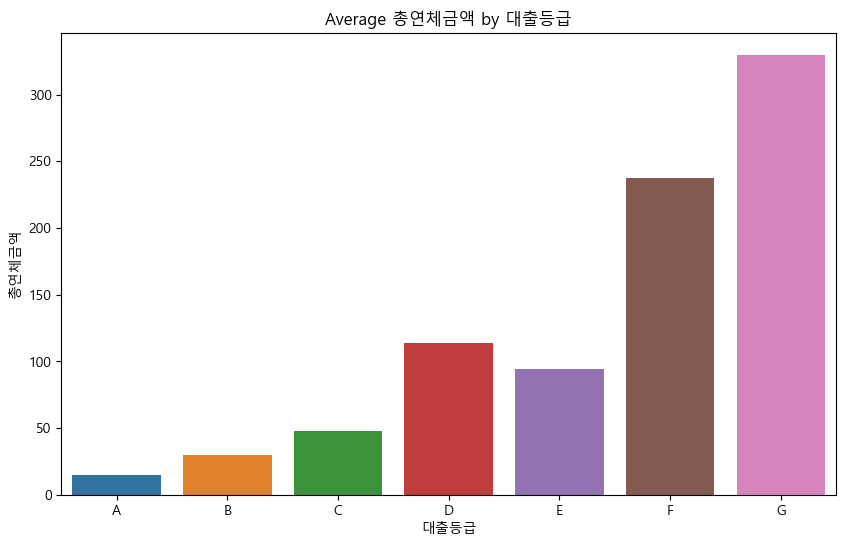

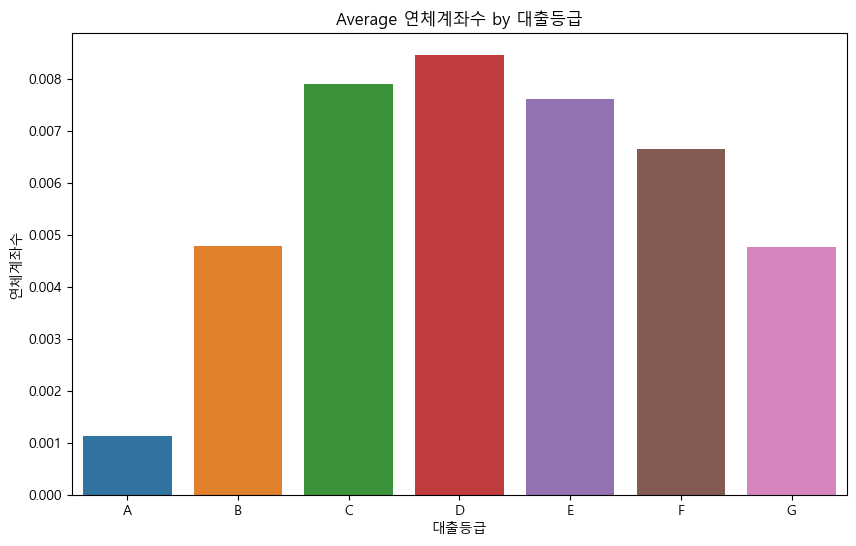

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

grouped_data = num_data.groupby('대출등급').mean().reset_index()

for column in grouped_data.columns:
    if grouped_data[column].dtype in ['float64', 'int64'] and column != '대출등급':
        plt.figure(figsize=(10, 6))
        sns.barplot(x='대출등급', y=column, data=grouped_data)
        plt.title(f'Average {column} by 대출등급')
        plt.show()

## 근로기간 (unknown값 포함 분석)

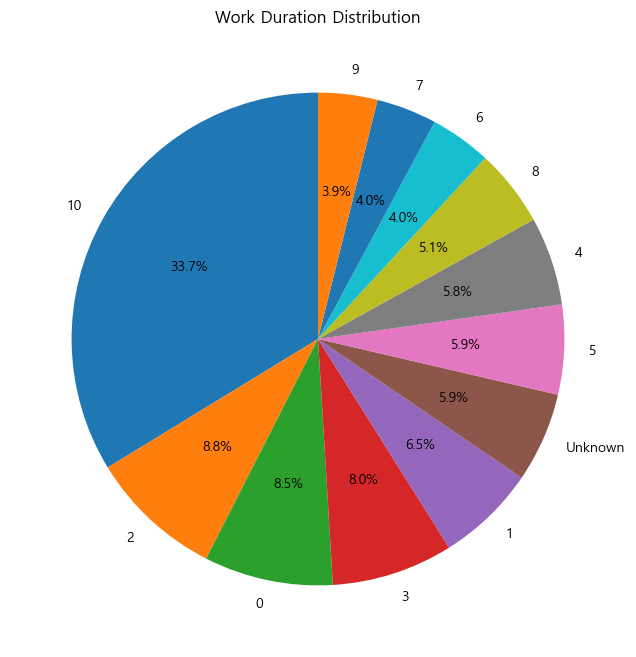

In [18]:
work_duration_counts = train_data['근로기간'].value_counts()
plt.figure(figsize=(10, 8))  
work_duration_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)  
plt.title('Work Duration Distribution')  
plt.ylabel('')  
plt.show() 

- 주어진 데이터셋에서는 신용등급이 낮은 데이터가 현저하게 적음. 반면 A등급과 같이 높은 신용등급 데이터는 많음.
- 또한 이 데이터에서 근무 기간이 10년 이상인 경우가 가장 많음. 따라서 신용등급이 A인 경우에는 근무 기간이 10년 이상인 비율이 높게 나타날 수 있음.
- 그러나 단순히 A등급이 10년 이상인 데이터가 많다고 해서 이를 유의미한 것으로 보기는 어려울 것 같음. 단순하게 A등급 10년 이상인 데이터가 많아서 나올 수도...
- 따라서 신용등급과 근무 기간 간의 관계 해석을 위해서는 추가적인 분석이 필요함

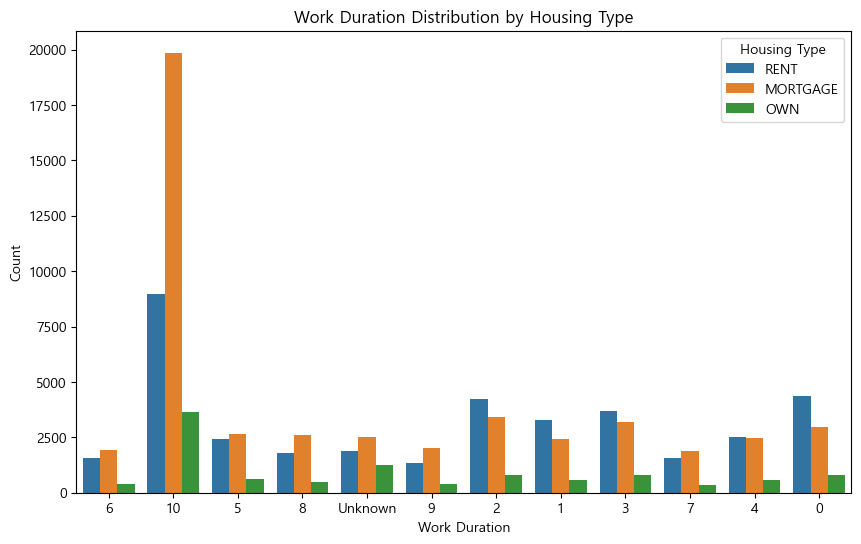

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='근로기간', hue='주택소유상태', data=train_data)
plt.title('Work Duration Distribution by Housing Type')
plt.xlabel('Work Duration')
plt.ylabel('Count')
plt.legend(title='Housing Type')
plt.show()

- 근무 기간에 따라 주택 소유 상태를 살펴본 결과, 근무 기간이 10년 이상인 경우 주택 소유 형태가 압도적으로 모기지임을 확인함. 
- 다른 근무 기간에서는 모기지 형태를 찾기가 어려웠으며, 대신 렌트 형태가 주택 소유 상태로 많이 나타남. 
- 이는 근무 기간이 길면 안정적인 주택 모기지 대출이 가능한 반면, 근무 기간이 짧은 경우에는 모기지 대출이 어렵고 렌트 형태로 주택을 확보하는 경향이 있다는 것을 유추할 수 있음. 
- 따라서 긴 근무 기간은 장기적 안정성을 고려하여 모기지 대출을, 짧은 근무 기간은 단기적 확실성을 고려하여 랜트 형태의 주택 소유를 고려해야 할 것.

In [20]:
train_data['근로기간'].unique()

array([6, 10, 5, 8, 'Unknown', 9, 2, 1, 3, 7, 4, 0], dtype=object)

c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


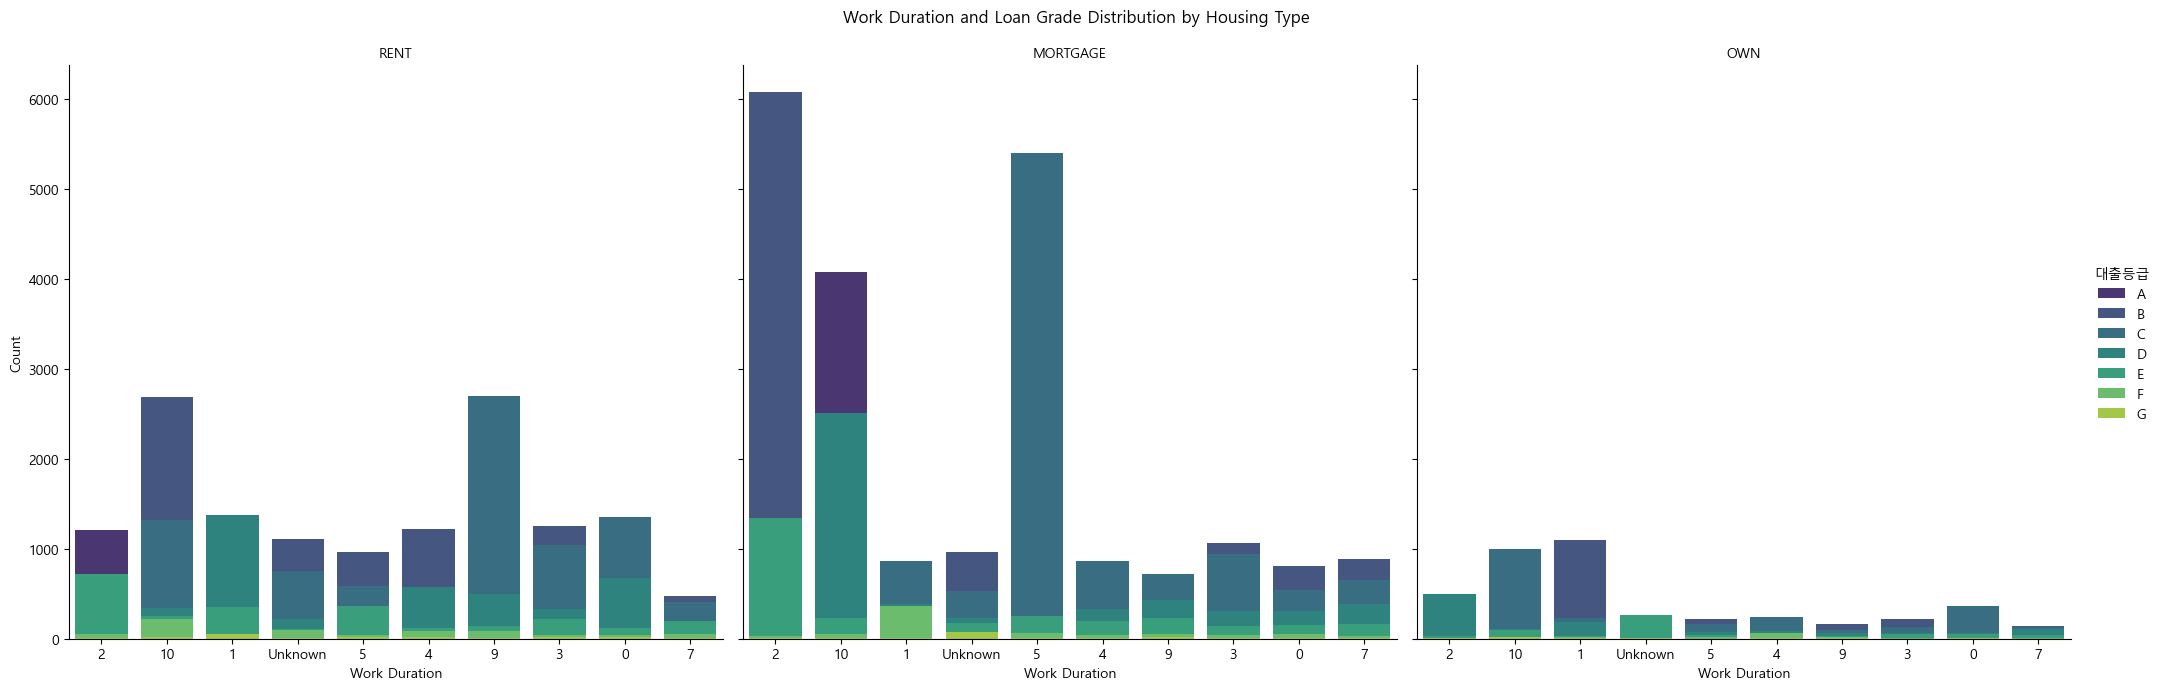

In [21]:
train_data['대출등급'] = pd.Categorical(train_data['대출등급'], categories=sorted(train_data['대출등급'].unique()))

g = sns.FacetGrid(train_data, col="주택소유상태", hue="대출등급", height=7, aspect=1, palette='viridis')

g.map(sns.countplot, "근로기간", hue_order=sorted(train_data['대출등급'].unique()))

g.add_legend(title='대출등급')
g.set_titles("{col_name}")
g.set_xlabels('Work Duration')
g.set_ylabels('Count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Work Duration and Loan Grade Distribution by Housing Type')

# Display the plot
plt.show()

- 주택 소유 형태별로 신용등급을 분석한 결과, 예상한 대로 안정적으로 장기 대출이 가능한 10+ 모기지 형태에서는 기관에서 A 신용등급을 받는 경향이 있었음.
- 신용등급 A는 모기지 형태에서 주택 소유를 보유한 경우에만 나타나는 특징으로 보임. 반면 근무 년수에 따른 다른 주택 소유 형태에서는 신용등급이 고르게 분포되어 있는 것으로 확인되었음.

c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


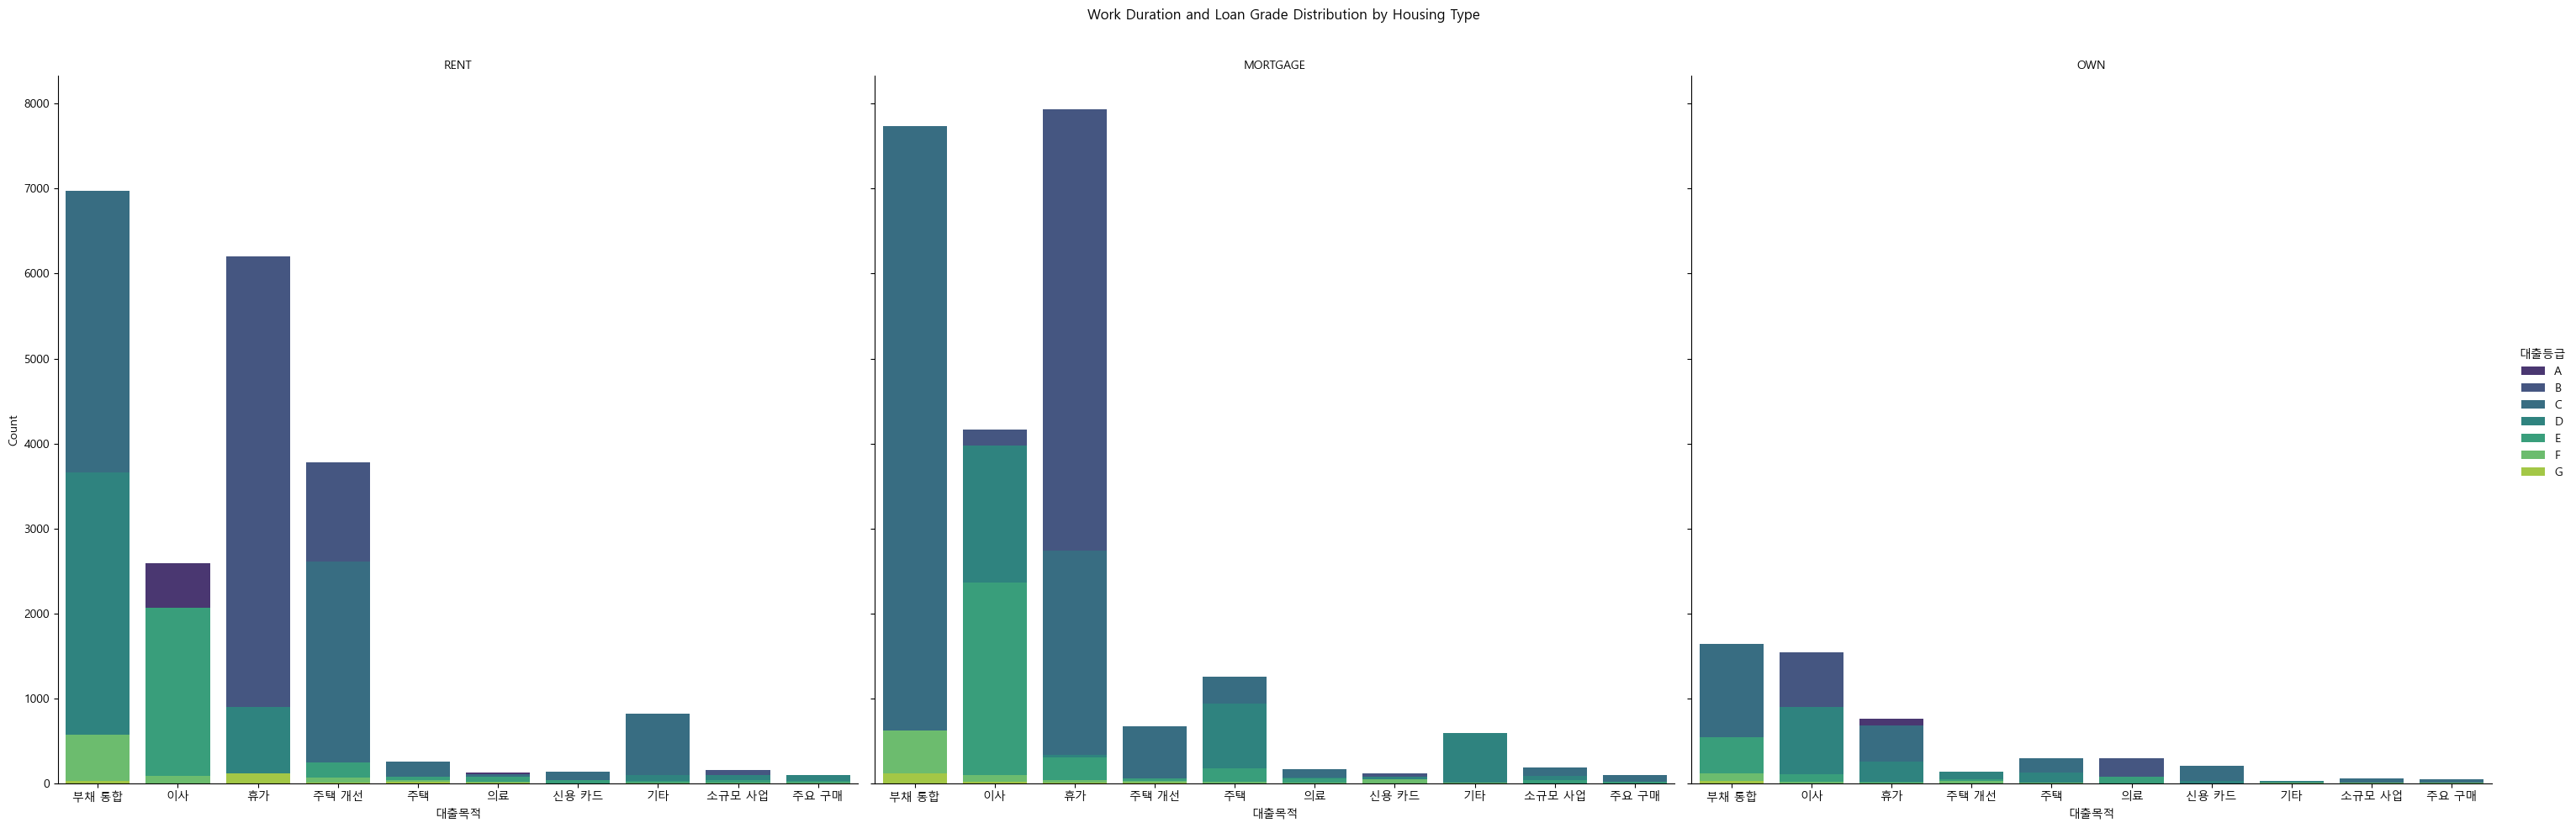

In [22]:
train_data['대출등급'] = pd.Categorical(train_data['대출등급'], categories=sorted(train_data['대출등급'].unique()))

g = sns.FacetGrid(train_data, col="주택소유상태", hue="대출등급", height=10, aspect=1, palette='viridis')

g.map(sns.countplot, "대출목적", hue_order=sorted(train_data['대출등급'].unique()))

g.add_legend(title='대출등급')
g.set_titles("{col_name}")
g.set_xlabels('대출목적')
g.set_ylabels('Count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Work Duration and Loan Grade Distribution by Housing Type')

# Display the plot
plt.show()


- 주택 소유 형태별로 어떤 대출 유형을 주로 하는지 관찰한 결과, 특별한 의미 있는 경향은 발견되지 않았음. 그러나 주목할 점은 신용카드 대출에서 A 신용등급이 많이 나타나는 것!. 
- 신용카드 대출에서는 A 신용등급이 여러 유형이 아니라 단일하게 나타나는 경향이 있음. 낮은 신용등급은 주로 부채 통합에서 결정되는 것으로 보임.

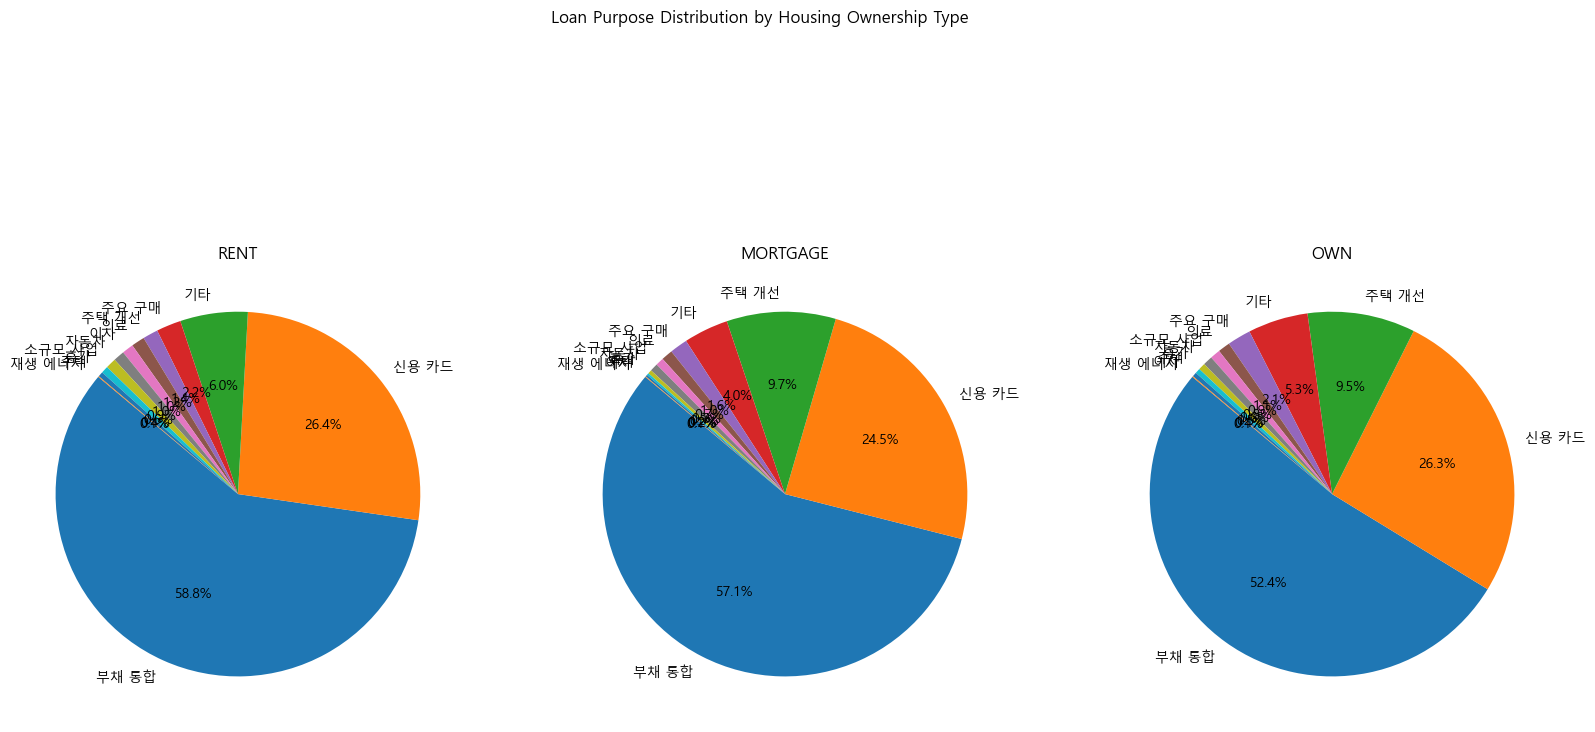

In [23]:
grouped = train_data.groupby('주택소유상태')['대출목적'].value_counts(normalize=True)

unique_housing_types = train_data['주택소유상태'].unique()
fig, axes = plt.subplots(1, len(unique_housing_types), figsize=(20, 10))

for ax, housing_type in zip(axes, unique_housing_types):

    data = grouped[housing_type]
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(housing_type)

plt.suptitle('Loan Purpose Distribution by Housing Ownership Type')
plt.show()

- 주택 소유 형태에 따른 대출 유형을 분석한 결과, 실제로 대부분의 경우 신용카드 대출이 주요 대출 유형으로 나타남. 
- 이는 대출 비중이 가장 큰 부채 통합과 함께 주택 소유자들이 주로 신용카드를 사용하고 있다는 것을 시사할 수 있음(추측). 
- 또한 A등급 신용을 판단하는 주요 요소로는 신용카드일 수 있음(추측).

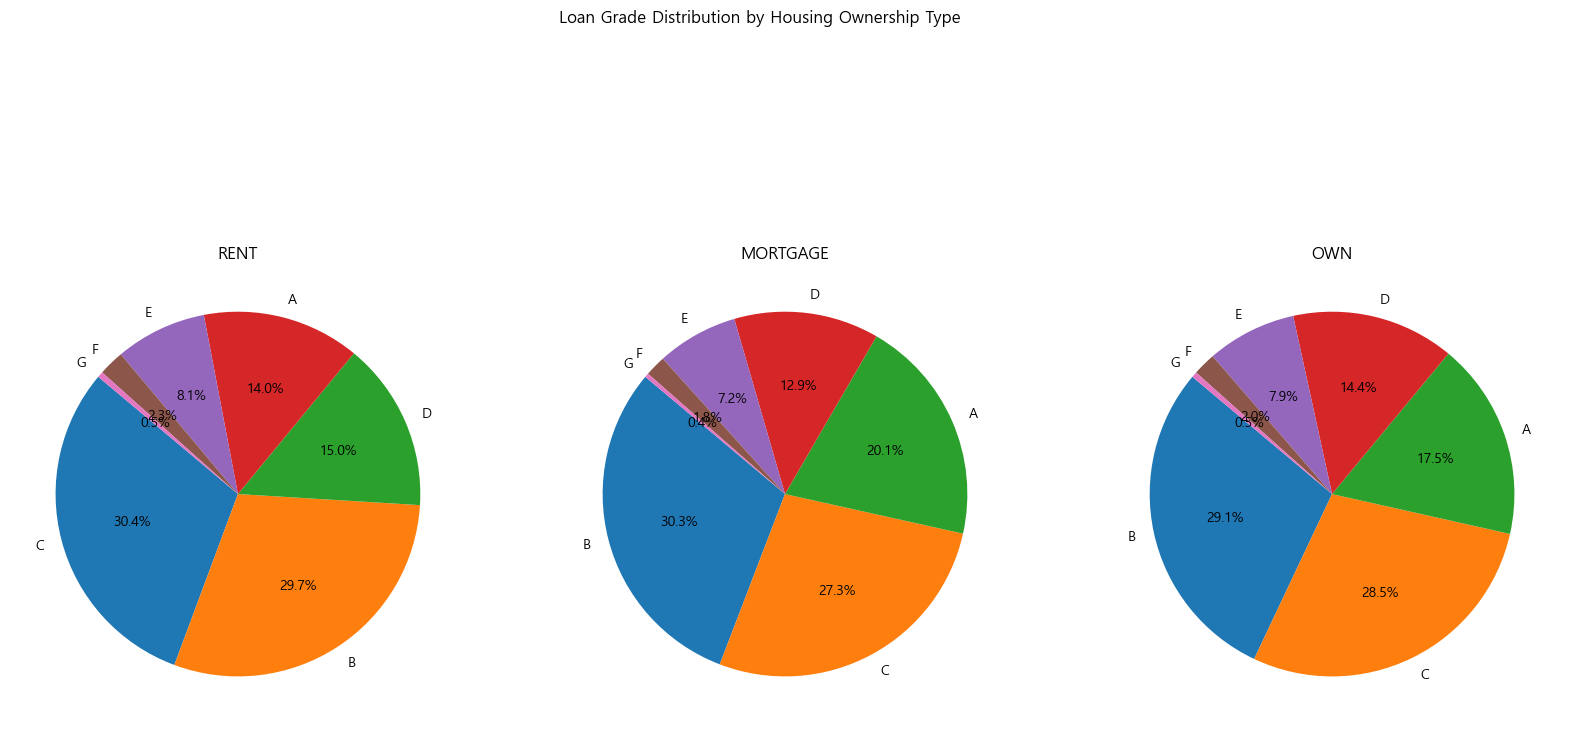

In [24]:
grouped = train_data.groupby('주택소유상태')['대출등급'].value_counts(normalize=True)

unique_housing_types = train_data['주택소유상태'].unique()
fig, axes = plt.subplots(1, len(unique_housing_types), figsize=(20, 10))

for ax, housing_type in zip(axes, unique_housing_types):
    data = grouped[housing_type]
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(housing_type)
plt.suptitle('Loan Grade Distribution by Housing Ownership Type')
plt.show()

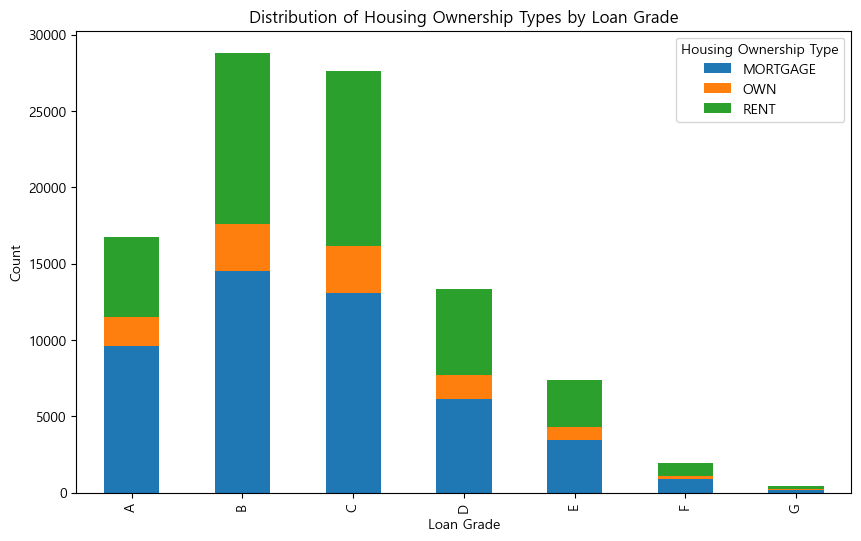

In [25]:
import matplotlib.pyplot as plt
import pandas as pd


grouped_housing = train_data.groupby(['대출등급', '주택소유상태']).size().unstack().fillna(0)

grouped_housing.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Distribution of Housing Ownership Types by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend(title='Housing Ownership Type')
plt.show()

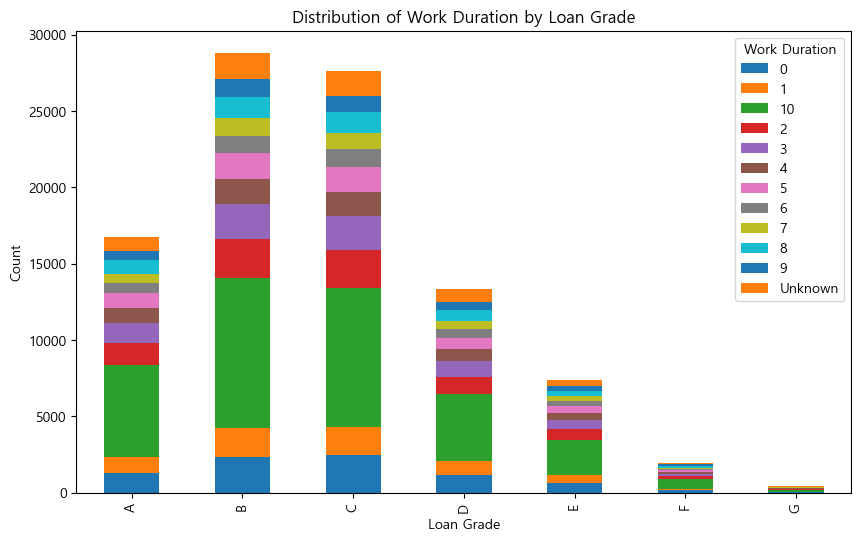

In [26]:
train_data['근로기간'] = train_data['근로기간'].astype(str)

grouped_work = train_data.groupby(['대출등급', '근로기간'], observed=True).size().unstack().fillna(0)

grouped_work.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Distribution of Work Duration by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend(title='Work Duration', loc='upper right')
plt.show()

- 주택 소유 형태가 모기지이며 근무 기간이 10년 이상인 경우가 가장 높은 신용등급을 받는 요소로 나타남. 
- 이는 모기지 형태가 가장 높은 안정성을 제공하며, 근무 기간이 긴 경우에는 대출 상환 능력을 보다 높게 평가하기 때문일 것이라 생각함(추측).

------